<a href="https://colab.research.google.com/github/tipiorgup/hands-on/blob/main/NN_hands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Welcome to the hands-on seminar**



**Objective:** Learn to use a neural network for energy correction based on structures.


We need to import source code and to install new packages

In [13]:
# If you chose to clone GitHub repo:
!git clone https://github.com/tipiorgup/hands-on.git

fatal: destination path 'hands-on' already exists and is not an empty directory.


In [2]:
!pip install ase

     |████████████████████████████████| 2.2 MB 4.9 MB/s 


In [14]:
import os                                                              
import time   
import pickle
import numpy as np                                                     
import pandas as pd   
import seaborn as sns                                                  
import matplotlib.pyplot as plt                                        
                                                                       
from sklearn.metrics import mean_absolute_error                        
from sklearn.metrics import mean_squared_error                         
from sklearn.model_selection import train_test_split                   
from sklearn.preprocessing import StandardScaler                       
from sklearn.model_selection import train_test_split                   
                                                                       
import keras                                                           
#from keras.optimizers import Adam                                      
from keras.models import Model, Sequential                             
from keras.layers import Input, Dense, Dropout, merge                  
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping   
                                                                       
import ase                                                             
import ase.build                                                       
from ase import Atoms                                                  
from ase.atoms import Atoms                                            
from ase.io import read, write                                         
from ase.calculators.dftb import Dftb                                  
from ase.units import Hartree, mol, kcal, Bohr                         
                                                                       
from Calculator import src_nogrd                                                       
from Calculator.src_nogrd import sym_func_show                                    
from Calculator.src_nogrd import xyzArr_generator                                 
from Calculator.src_nogrd import feat_scaling_func                                
from Calculator.src_nogrd import at_idx_map_generator                             
                                                                                                                           
import pickle                                                          
                                                                       
import Utils.DirNav                                                
from Utils.dftb_traj_io import read_scan_traj                          
import Utils.DirNav                                      
                                                                       
np.random.seed(98167)  # for reproducibility                           

ModuleNotFoundError: ignored

In [ ]:
# Global Var:
# Maintain: automatically find the number of features  

train_name = 'data'
save_name = 'data_model'
root_dir = '/nfs/home/lgomez/dftb-nn/Matched-H-comp/'
train_dir = os.path.join(root_dir, train_name)
save_dir = os.path.join(root_dir, save_name)
print(train_dir)
print(save_dir)


## Import structures ##
 <br/>
Properties will be read from the capture module.
* `md_train_arr` Molecular Structure (as ASE.Atoms object) 
* `md_dftb_ref_e_arr` and `md_pbe_ref_e_arr` DFTB and DFT relative energy (For Training)
<br/>

All of the energy has unit eV, and the distance is angstrom. Which is consistent with the ASE package. 

In [ ]:
geom_filename          = os.path.join(train_dir, 'EXTDstructures.xyz')
md_train_arr_origin    = read_scan_traj(filename=geom_filename)
md_low_rel_e_arr_name  = os.path.join(train_dir, 'TDkcalDFTB.dat')
md_high_rel_e_arr_name = os.path.join(train_dir, 'TDkcalB3LYP.dat')
try:
    md_dftb_ref_e_arr = np.loadtxt(md_low_rel_e_arr_name)
    md_pbe_ref_e_arr = np.loadtxt(md_high_rel_e_arr_name)
except:
    raise OSError("Cannot Read md_calc_rel_e_arr")
    #os.rmdir(save_dir)
    
print(md_dftb_ref_e_arr, md_pbe_ref_e_arr)
print("Before Copy")
print(md_train_arr_origin)
#WARNING: To Get the sample without index
md_train_arr = md_train_arr_origin.copy(deep=False).reset_index(drop=True)
print("After Copy")
print(md_train_arr)

md_rel_energy_arr = md_pbe_ref_e_arr - md_dftb_ref_e_arr
# Get rid of error values.
nan_index = np.where(np.isnan(md_rel_energy_arr))

for idx in nan_index:
    md_train_arr.drop(idx)
    md_rel_energy_arr = md_rel_energy_arr[~np.isnan(md_rel_energy_arr)]

[134.355   128.451   122.822   ...   2.96805   6.79122   1.79332] [79.0843  74.7075  70.5891  ...  3.7052  10.2218   8.65686]
Before Copy
0        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
1        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
2        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
3        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
4        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
                               ...                        
21233    (Atom('C', [-2.42533, -1.64533, -0.83133], ind...
21234    (Atom('C', [-3.38, 2.676, -1.234], index=0), A...
21235    (Atom('C', [-2.97667, 1.56933, -3.504], index=...
21236    (Atom('C', [-1.39067, -3.10333, -0.15333], ind...
21237    (Atom('C', [-3.70067, -0.61933, -0.33533], ind...
Length: 21238, dtype: object
After Copy
0        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
1        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
2        (Atom('C', [-0.806718, 0.0475439, 1.5251484], 

In [ ]:
print(md_train_arr_origin)

0        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
1        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
2        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
3        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
4        (Atom('C', [-0.806718, 0.0475439, 1.5251484], ...
                               ...                        
21233    (Atom('C', [-2.42533, -1.64533, -0.83133], ind...
21234    (Atom('C', [-3.38, 2.676, -1.234], index=0), A...
21235    (Atom('C', [-2.97667, 1.56933, -3.504], index=...
21236    (Atom('C', [-1.39067, -3.10333, -0.15333], ind...
21237    (Atom('C', [-3.70067, -0.61933, -0.33533], ind...
Length: 21238, dtype: object


In [ ]:
delta=md_pbe_ref_e_arr-md_dftb_ref_e_arr

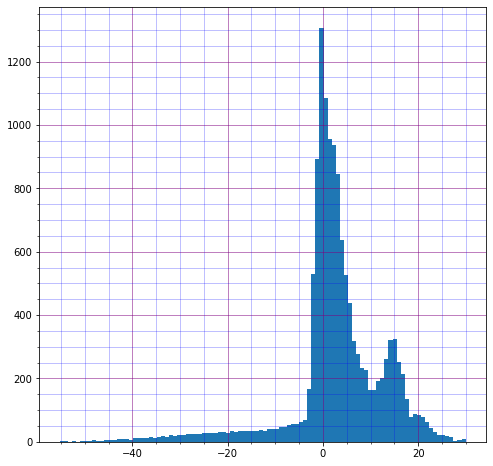

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(md_rel_energy_arr,bins=100)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='purple')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='blue', alpha=0.5)
plt.minorticks_on()
plt.show()

In [ ]:
extra = [i for i in delta if i<-2.5]

In [ ]:
def duplicate(testList, n):
     return testList*n

x=extra
extend=duplicate(x,5)

In [ ]:
len (extra)

1538

In [ ]:
len(extend)

7690

In [ ]:
md_rel_energy_arr=np.append(delta,extend)

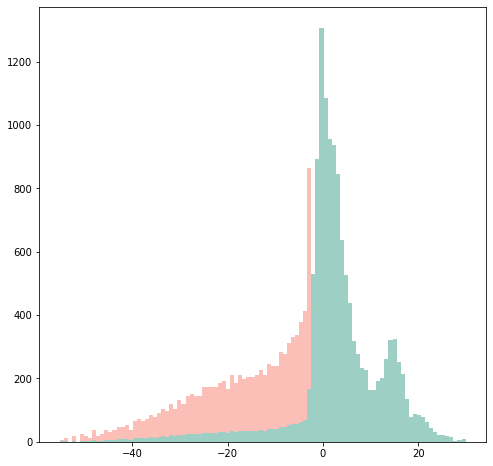

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(md_rel_energy_arr, bins=100, alpha=0.5, color='salmon')
plt.hist(delta, bins=100, alpha=0.5, color='turquoise')
plt.show()

In [ ]:
len(md_rel_energy_arr)

21238

(array([-20.,   0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 7 Text yticklabel objects>)

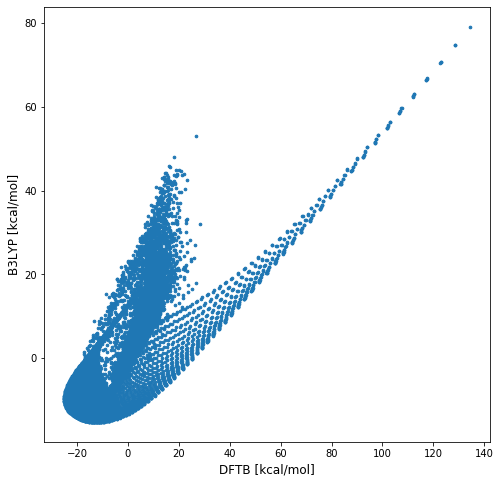

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(md_dftb_ref_e_arr, md_pbe_ref_e_arr,s=7)
plt.xlabel('DFTB [kcal/mol]', fontsize = 12)
plt.ylabel('B3LYP [kcal/mol]', fontsize = 12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

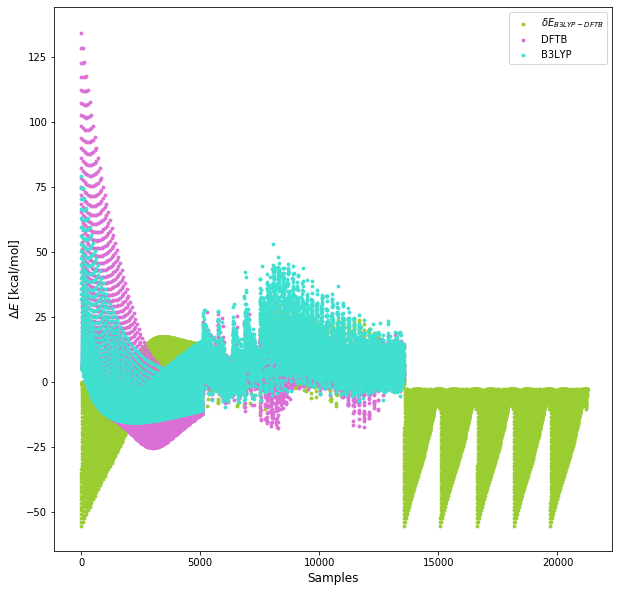

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(range(0,len(md_rel_energy_arr)), md_rel_energy_arr,s=8, color= "yellowgreen", label='$\delta E_{B3LYP-DFTB}$')
plt.scatter(range(0,len(md_dftb_ref_e_arr)), md_dftb_ref_e_arr,s=8, color= "orchid", label='DFTB')
plt.scatter(range(0,len(md_pbe_ref_e_arr)), md_pbe_ref_e_arr,s=8, color= "turquoise", label='B3LYP')
plt.xlabel('Samples', fontsize = 12)
plt.ylabel('$\Delta E$ [kcal/mol]', fontsize = 12)
plt.legend()
plt.show()

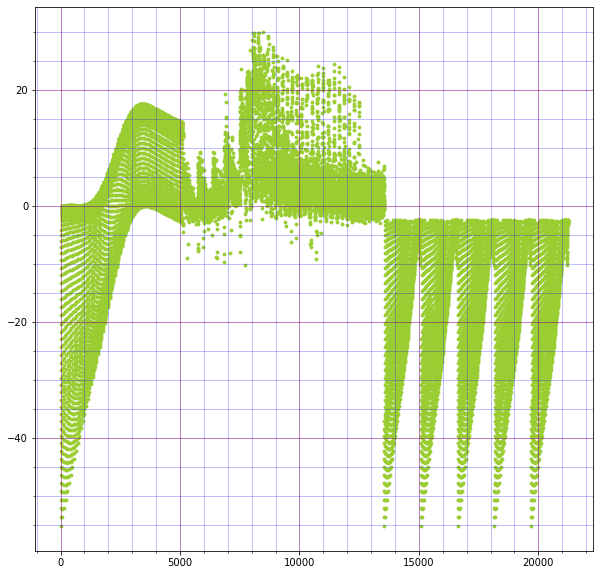

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(range(0,len(md_rel_energy_arr)), md_rel_energy_arr,s=8, color= "yellowgreen", label='$\delta E_{B3LYP-DFTB}$')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='purple')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='blue', alpha=0.5)
plt.minorticks_on()

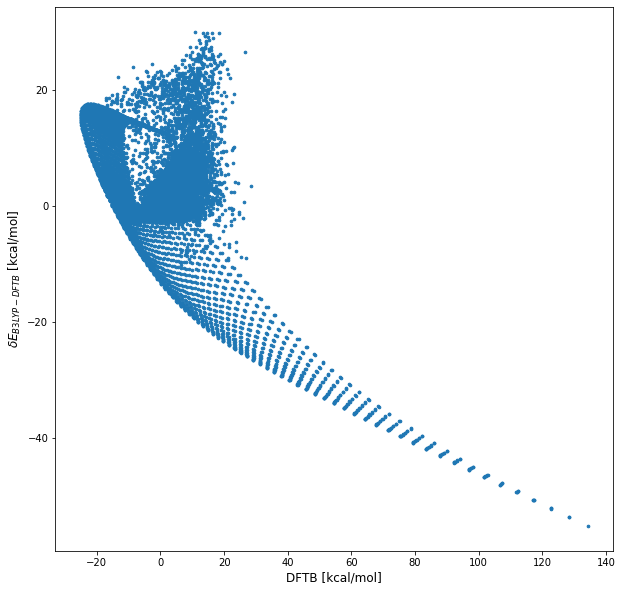

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(md_dftb_ref_e_arr, delta,s=7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('DFTB [kcal/mol]', fontsize = 12)
plt.ylabel('$\delta E_{B3LYP-DFTB}$ [kcal/mol]', fontsize = 12)
plt.show()

## Encode the Molecular Structure ##
While in Atomic Simulation Environment, the molecule is saved in terms of its xyz coordinates. For the neural network to work, the molecule needs to be converted into all of its distances and record all of its elements. 
* `distances` saves all the distances between each individual atoms. 
* `at_idx_map` saves all the atom indices that have the same element. 

In [ ]:
# Maintainence: Natom is a global variable 
# Assumes that the configuration does not change the Number of atoms. 
nAtoms, xyzArr = xyzArr_generator(md_train_arr)

In [ ]:
# Calculate distance dataframe from xyz coordinates
distances = src_nogrd.distances_from_xyz(xyzArr, nAtoms)
distances.head()
print(distances.shape)

(21238, 105)


In [ ]:
at_idx_map = at_idx_map_generator(md_train_arr[0])
print(at_idx_map)

{'C': array([ 0,  5, 10]), 'S': array([ 1,  6, 11]), 'H': array([ 2,  3,  4,  7,  8,  9, 12, 13, 14])}


In [ ]:
distances.min

<bound method DataFrame.min of          (0, 1)    (0, 2)    (0, 3)    (0, 4)    (0, 5)    (0, 6)    (0, 7)  \
0      1.841822  1.089281  1.087085  1.088321  3.469703  2.728914  3.170471   
1      1.841822  1.089281  1.087085  1.088321  3.469703  2.728914  3.170471   
2      1.841822  1.089281  1.087085  1.088321  3.469703  2.728914  3.170471   
3      1.841822  1.089281  1.087085  1.088321  3.469703  2.728914  3.170471   
4      1.841822  1.089281  1.087085  1.088321  3.469703  2.728914  3.170471   
...         ...       ...       ...       ...       ...       ...       ...   
21233  1.833248  1.088623  1.057450  3.768541  5.626064  6.071672  6.100369   
21234  1.921952  1.072054  1.098818  5.624144  8.564111  7.860929  9.622583   
21235  1.921172  1.071214  1.046996  4.756154  8.917629  8.406266  9.101220   
21236  1.761391  1.070187  1.077172  4.497522  7.129376  6.583867  7.944759   
21237  1.800667  1.045610  1.149391  4.500156  7.683782  6.998664  8.730155   

         (0, 8)    (

In [ ]:
np.amin(distances)

(0, 1)      1.705227
(0, 2)      0.994535
(0, 3)      0.985647
(0, 4)      1.088321
(0, 5)      2.961689
              ...   
(11, 13)    2.453408
(11, 14)    2.259159
(12, 13)    1.770488
(12, 14)    1.773562
(13, 14)    1.770989
Length: 105, dtype: float64

##  Generate the symmetry function vector ##
Symmetry Function is calculated from the Cartesian xyz coordinate and the element type of the individual atom. 

The radial and angular components of the symmetry functions (Gfuncs)
$$G_{i}^{\text{rad}} = \sum_{j \neq i} 
e^{-
\eta (R_{ij}-R_s)^2} 
$$

$$
G_{i}^{\text{ang}} = 2^{1-\zeta}\sum_{j \neq i} \sum_{k \neq i, j}  
 (1+\lambda \cos \theta_{ijk})^\zeta
e^{-\eta' (R_{ij}^2 + R_{ik}^2 + R_{jk}^2)} 
$$

A set of paramters, $(\eta, R_s)_{\text{rad}}$ and $(\zeta, \lambda, \eta')_{\text{ang}}$, characterized each set of features must be chosen to balance between the accuracy and the performance of the model.

### Set Parameters for the Symmetry Functions 
The parameters will be saved in the structure `Gparam_dict` to search for the symmetry function. 


**WARNING!!** Don't change the position of the hyperparameters in the array. The simplified routine are calculated based on that. Change the way the array is constructed is allows. But `ang_params` must always have `[eta, zeta, lambd]`

In [ ]:
    # radial symmetry function parameters
    # Need to automate the Rs_array part
    cutoff_rad = 10
    #Rs_array = np.linspace(0.8, 5, num=24)   # based on max and min of the distances
    Rs_array = np.linspace(0.2, 5, num=18)   # based on max and min of the distances
    eta_array = 5/(np.square(0.2*Rs_array))
    rad_params = np.array([(Rs_array[i], eta_array[i], cutoff_rad) for i in range(len(Rs_array)) ])



    # angular symmetry function parameters
    cutoff_ang = 5
    lambd_array = np.array([-1, 1])
    #zeta_array = np.array([1, 4, 16])
    zeta_array = np.array([1,4,16])
    #eta_ang_array = np.array([0.001, 0.01, 0.05])
    eta_ang_array = np.array( [0.001, 0.01, 0.05])
    
    # Each of the element need to be parametrized for all of the list. 
    angList = np.array(['CS', 'SS', 'CC','SH','HH','CH'])
    ang_comp = {'C':angList, 'S':angList, 'H':angList}
    ang_params = np.array([[eta, zeta, lambd, cutoff_ang] for eta in eta_ang_array for zeta in zeta_array for lambd in lambd_array])

    Gparam_dict = {}
    for at_type in at_idx_map.keys():
        Gparam_dict[at_type] = {}
        Gparam_dict[at_type]['rad'] = {}
        for at2_rad in sorted(at_idx_map.keys()):
                Gparam_dict[at_type]['rad'][at2_rad] = rad_params

        # This Section is already designed to be general
        Gparam_dict[at_type]['ang'] = {}
        for at23_ang in ang_comp[at_type]:
            Gparam_dict[at_type]['ang'][at23_ang] = ang_params



In [ ]:
print(rad_params)
print(ang_params)

[[2.00000000e-01 3.12500000e+03 1.00000000e+01]
 [4.82352941e-01 5.37254610e+02 1.00000000e+01]
 [7.64705882e-01 2.13757396e+02 1.00000000e+01]
 [1.04705882e+00 1.14016538e+02 1.00000000e+01]
 [1.32941176e+00 7.07279348e+01 1.00000000e+01]
 [1.61176471e+00 4.81179072e+01 1.00000000e+01]
 [1.89411765e+00 3.48414413e+01 1.00000000e+01]
 [2.17647059e+00 2.63878744e+01 1.00000000e+01]
 [2.45882353e+00 2.06754653e+01 1.00000000e+01]
 [2.74117647e+00 1.66355063e+01 1.00000000e+01]
 [3.02352941e+00 1.36735605e+01 1.00000000e+01]
 [3.30588235e+00 1.14376084e+01 1.00000000e+01]
 [3.58823529e+00 9.70841172e+00 1.00000000e+01]
 [3.87058824e+00 8.34364982e+00 1.00000000e+01]
 [4.15294118e+00 7.24767071e+00 1.00000000e+01]
 [4.43529412e+00 6.35426268e+00 1.00000000e+01]
 [4.71764706e+00 5.61641408e+00 1.00000000e+01]
 [5.00000000e+00 5.00000000e+00 1.00000000e+01]]
[[ 1.0e-03  1.0e+00 -1.0e+00  5.0e+00]
 [ 1.0e-03  1.0e+00  1.0e+00  5.0e+00]
 [ 1.0e-03  4.0e+00 -1.0e+00  5.0e+00]
 [ 1.0e-03  4.0e+0

### Generate the Symmetry Function Vectors for the molecule. 

In [ ]:
Gfunc_data = src_nogrd.symmetry_function(distances, at_idx_map, Gparam_dict)

## Visualize The Symmetry Function Vector 
The symmetry function is converted from the xyz coordinates of the atoms, and each atom has its own vector to describe its surrounding environment.  

21238 162


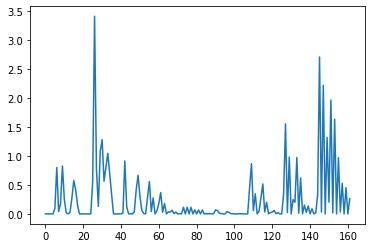

(21238, 162)


In [ ]:
sym_func_show(Gfunc_data, 'S',6,1)
print(Gfunc_data['S'][6].shape)

Seems that we have a bit more symmetry function

## Neural Network Building ##

In [ ]:
nUnit = 34 #int(os.environ['unit_number'])
def Nguyen_Widrow_init(shape, dtype=None):
    '''Nguyen-Widrow initialization for weights and biases
    Initialize the weight and biases for each layer.

            Args:
                shape: ???? (Guess: Shape of the layer to create)

            Output:
                [w,b]
                w: represents an array of weight
                b: represents an array of bias

    Comment:
    This is the function provided by Nguyen's original code.
    Junmian Zhu did the documentation. It is not 100% sure about the
    algorithm used here.

    '''
    n_input, n_unit = shape[0], shape[1]  # n_input: number of units of prev. layer without bias
    w_init = np.random.rand(n_input, n_unit) *2 -1
    norm = 0.7 * n_unit ** (1. / n_input)
    # normalize
    w = norm * w_init/np.sqrt(np.square(w_init).sum(axis=0).reshape(1, n_unit))
    if n_unit>1:
        b = norm * np.linspace(-1,1,n_unit) * np.sign(w[0,:])
    else:
        b = np.zeros((n_unit,))
    return [w, b]

def create_base_network_NoFirstDrop(input_dim, name):
    '''3-layer base network to be shared among atoms of the same species
    '''
    seq = Sequential()
    seq.add(Dense(nUnit, input_shape=(input_dim,), activation='tanh'))
    shape0 = (seq.layers[0].input_shape[1], seq.layers[0].output_shape[1])
    seq.layers[0].set_weights(Nguyen_Widrow_init(shape0))
    #seq.add(Dropout(0.1))

    seq.add(Dense(nUnit, activation='tanh'))
    shape1 = (seq.layers[1].input_shape[1], seq.layers[1].output_shape[1])
    seq.layers[1].set_weights(Nguyen_Widrow_init(shape1))
    seq.add(Dropout(rate=0))

    seq.add(Dense(nUnit, activation='tanh'))
    shape2 = (seq.layers[3].input_shape[1], seq.layers[3].output_shape[1])
    seq.layers[3].set_weights(Nguyen_Widrow_init(shape2))
    seq.add(Dropout(rate=0.015))

    seq.add(Dense(1, activation='linear'))
    shape3 = (seq.layers[5].input_shape[1], seq.layers[5].output_shape[1])
    seq.layers[5].set_weights(Nguyen_Widrow_init(shape3))
    seq.add(Dropout(rate=0.05))

    seq.name = name
    return seq

def create_base_network_NoDrop(input_dim, name):
    '''3-layer base network to be shared among atoms of the same species
    No Dropout Layers
    '''
    seq = Sequential()
    seq.add(Dense(nUnit, input_shape=(input_dim,), activation='tanh'))
    shape0 = (seq.layers[0].input_shape[1], seq.layers[0].output_shape[1])
    seq.layers[0].set_weights(Nguyen_Widrow_init(shape0))

    seq.add(Dense(nUnit, activation='tanh'))
    shape1 = (seq.layers[1].input_shape[1], seq.layers[1].output_shape[1])
    seq.layers[1].set_weights(Nguyen_Widrow_init(shape1))

    seq.add(Dense(nUnit, activation='tanh'))
    shape2 = (seq.layers[2].input_shape[1], seq.layers[2].output_shape[1])
    seq.layers[2].set_weights(Nguyen_Widrow_init(shape2))

    seq.add(Dense(1, activation='linear'))
    shape3 = (seq.layers[3].input_shape[1], seq.layers[3].output_shape[1])
    seq.layers[3].set_weights(Nguyen_Widrow_init(shape3))

    seq.name = name
    return seq

def main_network(input_dim_list, at_idx_map, DropOut):
    '''
    Main neural network with shared sub-structures.
    Currently it supports a sub-network with additional features.
    '''
    type_nb = len(input_dim_list)
    element_network = {}
    inp = {'element':{}, 'rc':{}}

    element_processed = {}  # Will keep the input of the atomic symmetry function
    #rc_processed = []       # Will keep the input of the features, Mulliken Charge of the atom, etc.

    # The sub-network that computes E(RC), the correction for geometry
    # dims[2] = number of features in the second input.
    # Assume that it must have hydrogen
    #rc_network = create_base_network(input_dim_list['H'][1], "rc-subnet")
    # atomic inputs of the same species are processed through the same sub-network.


    #for at_type in range(type_nb):
    for at_type in at_idx_map:
        dims = input_dim_list[at_type]
        # Create a sub-network for each element.
        if DropOut == 'NoDrop':
            element_network[at_type] = create_base_network_NoDrop(dims[0], at_type + '-subnet')
        elif DropOut == 'NoFirstDrop':
            element_network[at_type] = create_base_network_NoFirstDrop(dims[0], at_type + '-subnet')

        element_processed[at_type] = {}
        inp['element'][at_type] = {}
        #inp['rc'][at_type]  = {}
        #for atA in range(dims[0]):
        for atA in at_idx_map[at_type]:
            # input preparation
            inp['element'][at_type][atA] = Input(shape=(dims[0],),dtype='float32', name=at_type+'-'+str(atA)+'-ele')
            #inp['rc'][at_type][atA]      = Input(shape=(dims[1],),dtype='float32', name=at_type+'-'+str(atA)+'-rc')

            # because we re-use the same instance `base_network`,
            # the weights of the sub-network will be shared across same-type atomic branches
            element_processed[at_type][atA] = element_network[at_type](inp['element'][at_type][atA])
            #rc_processed.append(rc_network(inp['rc'][at_type][atA]))


    # Define the output (predicted total energy) as a sum of all atomic energies
    element_outputs = [element_processed[u][v] for u in element_processed.keys() for v in element_processed[u].keys()]
    total_outputs = element_outputs #+ rc_processed
    main_output = keras.layers.add(total_outputs)

    # Organize the input structure by using the structure as the network defined above.
    # because Keras will take multiple input one by one according to the sequence.
    inputs = []
    #for at_type in range(type_nb):
    for at_type in at_idx_map:
        dims = input_dim_list[at_type]

        #for atA in range(dims[0]):
        for atA in at_idx_map[at_type]:
            inputs.append(inp['element'][at_type][atA])
            #inputs.append(inp['rc'][at_type][atA])

    # Finalizing building the main network model.
    main_network = Model(inputs, main_output)

    return main_network




In [ ]:
# Glboal Var
n_samples = len(md_train_arr)


# Maintainence // Problem: In case we have no atom for that particular element, 
# it is difficult to give the input dimension
    
# Maintain: I assume that same amount of symmetry function is used for each atom  
# Maintain: Need a input_dim_list_generator function in the future
"""
def input_dim_list_generator(element):
    # In case of element with 0 atoms in the configuration
    nAtomsForEle = len(at_idx_map(element));
    if len nAtomsForEle == 0:
        return (nAtomsForEle, )
        """
#nSymFunc = Gfunc_data['O'][0].shape[1]
n_symm_func = Gfunc_data['C'][  at_idx_map['C'][0]].shape[1]
#input_dim_list = [(len(at_idx_map[at]) ,nSymFunc, nb_feat) for at in at_idx_map.keys()]

input_dim_list = {}
for at_type in at_idx_map:
    input_dim_list[at_type] = (n_symm_func, 1)

In [ ]:
Mode='NoFirstDrop'
#model = main_network(input_dim_list)
model = main_network(input_dim_list, at_idx_map, 'NoFirstDrop')
model.summary()

W0602 15:42:49.496083 139698077533568 deprecation_wrapper.py:119] From /home/lgomez/anaconda3/envs/dftb-nn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0602 15:42:49.522390 139698077533568 deprecation_wrapper.py:119] From /home/lgomez/anaconda3/envs/dftb-nn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0602 15:42:49.525051 139698077533568 deprecation_wrapper.py:119] From /home/lgomez/anaconda3/envs/dftb-nn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0602 15:42:49.541276 139698077533568 deprecation_wrapper.py:119] From /home/lgomez/anaconda3/envs/dftb-nn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session i

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C-0-ele (InputLayer)            (None, 162)          0                                            
__________________________________________________________________________________________________
C-5-ele (InputLayer)            (None, 162)          0                                            
__________________________________________________________________________________________________
C-10-ele (InputLayer)           (None, 162)          0                                            
__________________________________________________________________________________________________
S-1-ele (InputLayer)            (None, 162)          0                                            
__________________________________________________________________________________________________
S-6-ele (I

## Symmetry Function Pre-Processing ##

In [ ]:
def idx_generator(n_samples, val_ratio, test_ratio):
    """
    Function:
    Randomly shuffle the indexes and to generate indexes for the training, validation and test set.
    
        Args:
            n_samples: number of samples, an interger
            val_ratio: ratio of the validation set (compared with all data set)
            test_ratio: 
    
        Warning: 0 < val_ratio + test_ratio < 1.
    
        Output:
            train_idx: indexes for training set
            val_idx: indexes for the validation set
            test_idx: indexes for the test set    
    """
    if val_ratio + test_ratio >= 1 or val_ratio + test_ratio <= 0:
        raise  ValueError("idx_generator: the val_ratio and test_ratio must be in between 0 and 1")
    
    shuffled_indices = np.random.permutation(n_samples)
    
    
    val_set_size = int(n_samples * val_ratio)
    val_idx  = shuffled_indices[:val_set_size]
    
    test_set_size= int(n_samples * val_ratio)
    test_idx = shuffled_indices[val_set_size:val_set_size+test_set_size]
    
    train_idx = shuffled_indices[val_set_size + test_set_size:]
    
    return train_idx, val_idx, test_idx

## Split the Training, Validation & Test Data ##

In [ ]:
## Split the Training, Validation & Test Data 
train_idx, val_idx, test_idx = idx_generator(n_samples, 0.1,0.1)
print(train_idx.shape)
print(val_idx.shape)
# Check whether it is totally splitted
if train_idx.shape[0] + test_idx.shape[0] + val_idx.shape[0] != n_samples:
    raise ValueError("Splitting Test does not equal to the entire set!")

(16992,)
(2123,)


In [ ]:
# rescale target values 
# All training values in kcal/mol unit

y_train = md_rel_energy_arr[train_idx] 
y_val   = md_rel_energy_arr[val_idx]
y_test  = md_rel_energy_arr[test_idx] 

In [ ]:
print('y_train min, max = ', '%.5f  %.5f' %(y_train.min(), y_train.max() ))
print('y_test min, max = ', '%.5f  %.5f' %(y_test.min(), y_test.max()) )

y_train min, max =  -55.27070  29.79190
y_test min, max =  -53.74160  25.16634


In [ ]:
md_rel_energy_arr.min()

-55.27069999999999

In [ ]:
md_rel_energy_arr.max()

29.9632

In [ ]:

def split_training_data(Feat_data, at_idx_map, train_idx, val_idx, test_idx):
    """
    Function:
    Split the training set, 
        
    Input:
    Feat_data_train: Strucutre for the feat data Feat_data_train['element'][atom]
    at_idx_map: Atom Index Map
    train_idx: the indices used for the training 
    
    
    Output:
    Return the Feat_train, Feat_val and Feat_test set in the shape
    Feat_scaler['element'][atom][Feature Number]    
    """
    
    
    Feat_train_scaled = {}
    Feat_val_scaled = {}
    Feat_test_scaled = {}

    
    for at_type in at_idx_map.keys():
        Feat_train_scaled[at_type] = {}
        Feat_val_scaled[at_type] = {}
        Feat_test_scaled[at_type] = {}
        
        for at in at_idx_map[at_type]:
            Feat_train_scaled[at_type][at] = Feat_data[at_type][at][train_idx,]
            #import pdb; pdb.set_trace()
            Feat_val_scaled[at_type][at]   = Feat_data[at_type][at][val_idx,]
            Feat_test_scaled[at_type][at]  = Feat_data[at_type][at][test_idx,]
            

            
    
    return Feat_train_scaled, Feat_val_scaled, Feat_test_scaled


In [ ]:
train_scaled, val_scaled, test_scaled = split_training_data(Gfunc_data, at_idx_map, train_idx, val_idx, test_idx)
print(test_scaled['C'][0].shape)
#Feat_train_scaled, Feat_val_scaled, Feat_test_scaled = split_training_data(Feat_data, at_idx_map, train_idx, val_idx, test_idx)
#print(Feat_train_scaled['H'][4].shape)


(2123, 162)


In [ ]:
inp_train = []
inp_val   = []
inp_test  = []
for at_type in at_idx_map.keys():

    for atA in at_idx_map[at_type]:
        inp_train.append(train_scaled[at_type][atA])
        #inp_train.append(Feat_train_scaled[at_type][atA])
        
        inp_val.append(val_scaled[at_type][atA])
        #inp_val.append(Feat_val_scaled[at_type][atA])
        
        inp_test.append(test_scaled[at_type][atA])
        #inp_test.append(Feat_test_scaled[at_type][atA])
        


In [ ]:
def get_inp(at_idx_map, Gfunc_scaled, Feat_scaled):
    inp_arr = []
    for at_type in at_idx_map.keys():
        for at_idx in at_idx_map[at_type]:
            inp_arr.append(Gfunc_scaled[at_type][at_idx])
            inp_arr.append(Feat_scaled[at_type][at_idx])
    
    return pd.Series(inp_arr)

## Neural Network Training ##

We applied the Early Stopping Method and gradually decrease the learning rate to improve the training of the sample.

In [ ]:
model_folder = "model_2B_nUnit"
!mkdir $model_folder

check1 = model_folder +'/' + str(nUnit) + '.hdf5'
checkpointer = ModelCheckpoint(filepath=check1, verbose=0,  monitor='val_mean_squared_error',\
                               mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=100, verbose=0)

#Mode == 'NoFirstDrop':


mkdir: cannot create directory 'model_2B_nUnit': File exists


W0602 15:42:56.918783 139698077533568 deprecation_wrapper.py:119] From /home/lgomez/anaconda3/envs/dftb-nn/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Training Session 1: Learning Rate 0.1


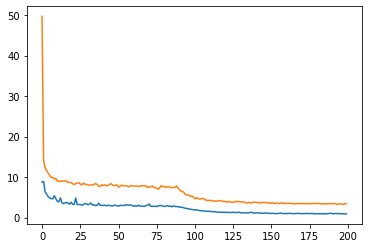

In [ ]:
print("Training Session 1: Learning Rate", 0.1)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.1,decay=0.01),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(inp_train, y_train, \
                    callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=200, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.show()

Training Session 2: Learning Rate 0.01


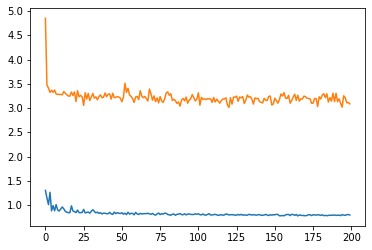

In [ ]:
print("Training Session 2: Learning Rate", 0.01)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.01,decay=0.01),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history2 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=200, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history2.history['val_mean_squared_error'])
plt.plot(history2.history['mean_squared_error'])
plt.show()

Training Session 3: Learning Rate 0.01


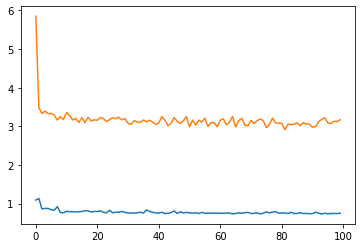

In [ ]:
print("Training Session 3: Learning Rate", 0.01)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.01,decay=0.01),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history3 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=100, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history3.history['val_mean_squared_error'])
plt.plot(history3.history['mean_squared_error'])
plt.show()

Training Session 4: Learning Rate 0.001


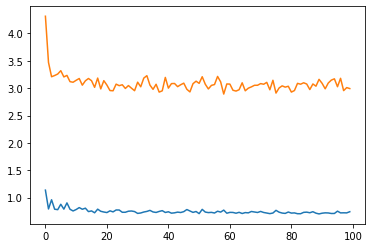

In [ ]:
print("Training Session 4: Learning Rate", 0.001)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.01,decay=0.01),
              metrics=['mean_squared_error', 'mean_absolute_error'])


history4 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=100, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history4.history['val_mean_squared_error'])
plt.plot(history4.history['mean_squared_error'])
plt.show()

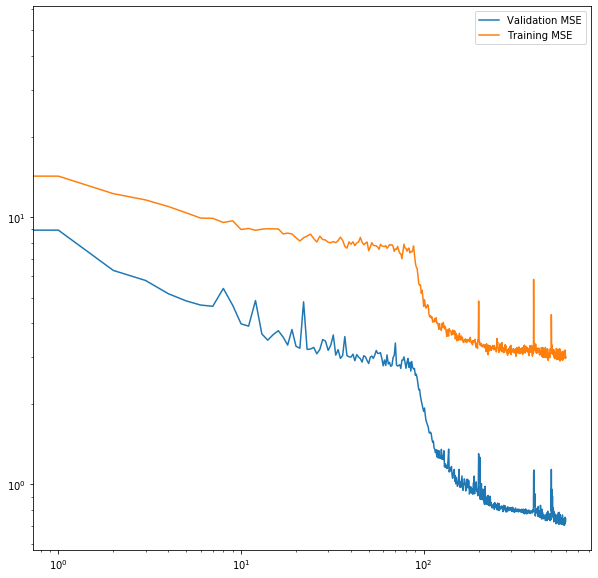

In [ ]:
plt.figure(figsize=(10,10))
plt.loglog(history.history['val_mean_squared_error'] + history2.history['val_mean_squared_error'] \
           + history3.history['val_mean_squared_error']+ history4.history['val_mean_squared_error'] \
           , label='Validation MSE')
plt.loglog(history.history['mean_squared_error'] + history2.history['mean_squared_error']\
           + history3.history['mean_squared_error']+ history4.history['mean_squared_error'] \
           , label='Training MSE')
plt.legend()
plt.show()

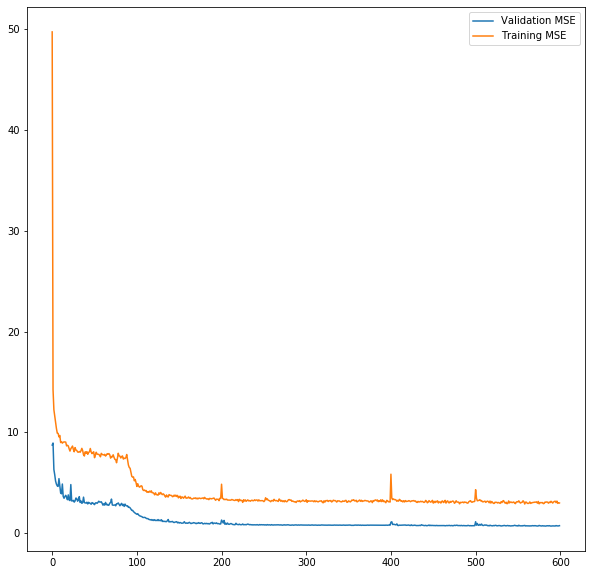

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['val_mean_squared_error'] + history2.history['val_mean_squared_error'] \
           + history3.history['val_mean_squared_error']+ history4.history['val_mean_squared_error'] \
           , label='Validation MSE')
plt.plot(history.history['mean_squared_error'] + history2.history['mean_squared_error']\
           + history3.history['mean_squared_error']+ history4.history['mean_squared_error'] \
           , label='Training MSE')
plt.legend()
plt.show()

## Model Evaluation ##

In [ ]:
# Load model weights
model.load_weights(check1)

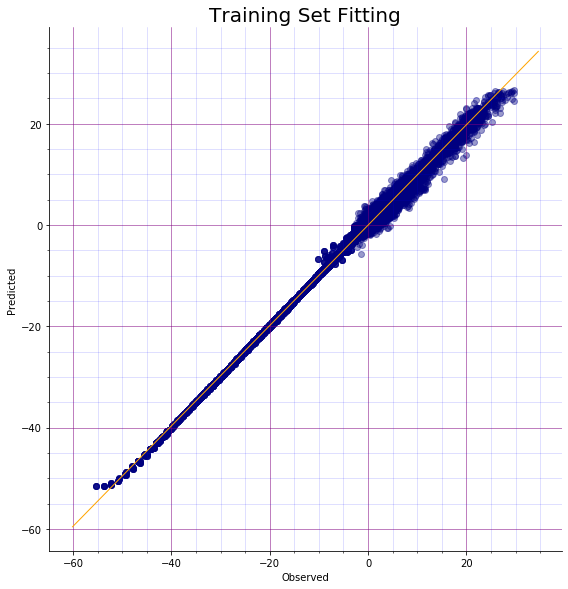

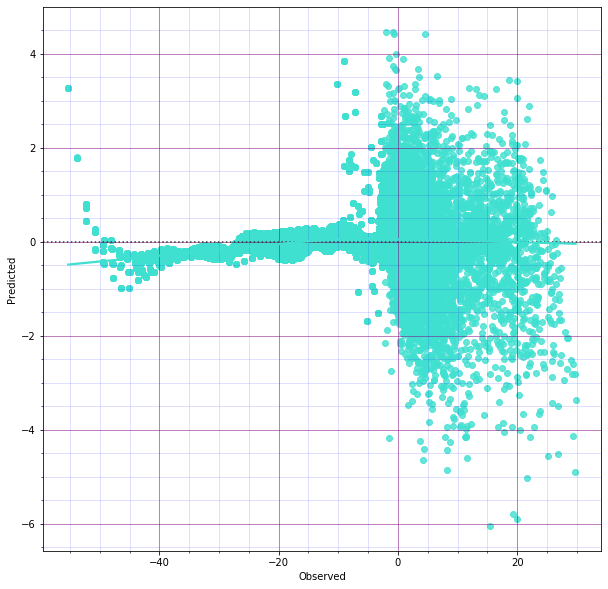

In [ ]:
y_pred_scaled_train = model.predict(inp_train)
y_pred_train = y_pred_scaled_train.T[0] # Transpose the np.array
y_obs_train = y_train


x2 = pd.Series(y_pred_train, name="Predicted")
x1 = pd.Series(y_obs_train, name="Observed")

data1 = pd.concat([x1, x2], axis=1)
g = sns.lmplot("Observed", "Predicted", data1,
           scatter_kws={"marker": ".", "color": "navy", "alpha": 0.4 },
           line_kws={"linewidth": 1, "color": "orange"},
              height=8, aspect=1);
plt.plot(ls="--", c=".1")
plt.grid(which='major', linestyle='-', linewidth='0.5', color='purple')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='blue', alpha=0.25)
plt.minorticks_on()
plt.title('Training Set Fitting', fontsize=20)

plt.figure(figsize=(10,10))
sns.residplot(x1, x2, lowess=True, color="turquoise")
plt.plot(ls="--", c=".1")
plt.grid(which='major', linestyle='-', linewidth='0.5', color='purple')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='blue', alpha=0.25)
plt.minorticks_on()

In [ ]:
# Error on TEST set 
y_pred_scaled = model.predict(inp_test)
y_pred = y_pred_scaled.T[0]  # in kcal/mol unit
y_obs = y_test #/Eunit

err_test = np.sqrt(mean_squared_error(y_pred, y_obs))
errAbs_test = mean_absolute_error(y_pred, y_obs) 
print('RMSE_test:', '%.4f' % err_test)
print('MAE_test:','%.4f' % errAbs_test)
#print('The mean value of energies in test set: ', '%.4f' %E_ref_orig[test_idx].mean())

RMSE_test: 0.8113
MAE_test: 0.4838


Text(0.5, 1, 'Test Set Prediction')

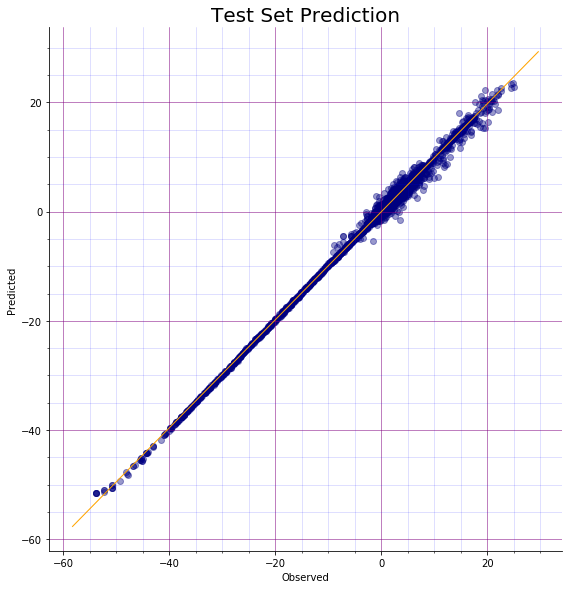

In [ ]:
# Scatter plot of predicted and true values of energies in the test set
x2 = pd.Series(y_pred, name="Predicted")
x1 = pd.Series(y_obs, name="Observed")

data1 = pd.concat([x1, x2], axis=1)
g = sns.lmplot("Observed", "Predicted", data1,
           scatter_kws={"marker": ".", "color": "navy", "alpha": 0.4 },
           line_kws={"linewidth": 1, "color": "orange"},
           height=8, aspect=1);
plt.plot(ls="--", c=".1")
plt.grid(which='major', linestyle='-', linewidth='0.5', color='purple')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='blue', alpha=0.25)
plt.minorticks_on()
plt.title('Test Set Prediction', fontsize=20)

In [ ]:
# model.layers[21]
save_dir

'/nfs/home/lgomez/dftb-nn/Matched-H-comp/data_model'

## Save the Model ##
All the weights of the model will be saved to run calculations on new samples. 

In [ ]:
from keras.models import load_model

In [ ]:
#TODO: Automatically collects all the sublayers. 
model.get_layer("S-subnet").save(os.path.join(save_dir, 'S-subnet.h5'))
model.get_layer("C-subnet").save(os.path.join(save_dir, 'C-subnet.h5'))
model.get_layer("C-subnet").save(os.path.join(save_dir, 'H-subnet.h5'))


In [ ]:
model.save(os.path.join(save_dir, 'model.h5'))

## Save the Test data ##

In [ ]:
def write_np_arr_to_pkl(np_arr, save_dir, file_name):
    with open(os.path.join(save_dir, file_name), "wb") as pkl_file:
        pickle.dump(np_arr, pkl_file)    

In [ ]:
write_np_arr_to_pkl(inp_test,save_dir,  "inp_test.pkl")
write_np_arr_to_pkl(y_pred,save_dir,  "y_pred.pkl")
write_np_arr_to_pkl(y_obs, save_dir, "y_obs.pkl")

In [ ]:
def write_keras_subnet_ind(model, save_dir, subnet_name):
    """
    Write the given subnet of keras model to file.
    
    For a given keras model (model), with the given Name of the subbnet (subnet_name, save
    the model to json file and the weight to a h5 file. 
    
        Args:
            model: a keras model for the entire nested network.
            subnet_name: the name for the sub neural network as in model.summary()
        
        Outputs:
            No Return Value.
            Save the given sub neural network in the ../folder. 
            The architecture is saved in 'subnet_name.json'
            The weight is saved in 'subnet_name-weight.h5'
            
    Comments:
    Needs to run the shell script to clean all the data
    """
    subnet = model.get_layer(subnet_name)
    subnet.save_weights(os.path.join(save_dir, subnet_name + '-weight.h5'))
    subnet_json = subnet.to_json()
    with open(os.path.join(save_dir, subnet_name+".json"), "w") as json_file:
        json_file.write(subnet_json)

In [ ]:
write_keras_subnet_ind(model, save_dir, 'S-subnet')
write_keras_subnet_ind(model, save_dir, 'C-subnet')
write_keras_subnet_ind(model, save_dir, 'H-subnet')

In [ ]:
## Warning:
## Don't do that in the future
write_np_arr_to_pkl(Gfunc_data, save_dir, "Gfunc_data_test.pkl")
#write_np_arr_to_pkl(Feat_data, save_dir, "Feat_data_test.pkl")

In [ ]:
write_np_arr_to_pkl(Gparam_dict, save_dir,  "Gparam_dict.pkl")
write_np_arr_to_pkl(at_idx_map, save_dir, "at_idx_map.pkl")

In [ ]:
rel_e_ref = pd.Series([]) 
rel_e_ref['dft']  = 0 
rel_e_ref['calc'] = 0
write_np_arr_to_pkl(rel_e_ref, save_dir, "rel_e_ref.pkl")